# Electrocardiogram (ECG) Signal
An Electrocardiogram (ECG or EKG) signal is a recording of the electrical activity of the heart over a period of time. This signal is captured using electrodes placed on the skin, typically on the chest, arms, and legs. The ECG signal provides vital information about the heart's rhythm and electrical conduction patterns, which are crucial for diagnosing various cardiac conditions.

## Objectives 
The primary objective of this project was to classify ECG signals into different categories, identifying normal and abnormal heartbeats using machine learning techniques. The dataset used comprised various types of ECG signals, which were preprocessed and then used to train and evaluate multiple classification models. The methods involved data cleaning, feature extraction, model training, and performance evaluation.

# Import the necessary libraries

In [1]:
import wfdb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings 
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore')

2024-06-23 10:05:51.286833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 10:05:51.286938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 10:05:51.429101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Download the MIT-BIH Arrhythmia Database dataset

In [2]:
# Define the URL and local extraction path
url = "https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
extraction_dir = os.path.join(os.getcwd(), "mit-bih-arrhythmia-database")

# Download and extract the dataset
dataset_path = keras.utils.get_file(
    fname="mit-bih-arrhythmia-database-1.0.0.zip",
    origin=url,
    extract=True,
    archive_format="zip",
    cache_dir=".",
    cache_subdir=extraction_dir
)

# The dataset_path should now point to the directory where the data is extracted
extracted_dir = extraction_dir
print(f"Dataset directory: {extracted_dir}")

77030320/77030320 ━━━━━━━━━━━━━━━━━━━━ 104s 1us/step
Dataset directory: /kaggle/working/mit-bih-arrhythmia-database


In [3]:
os.listdir(extraction_dir)

['mit-bih-arrhythmia-database-1.0.0.zip', 'mit-bih-arrhythmia-database-1.0.0']

In [4]:
# The dataset_path should now point to the directory where the data is extracted
dataset_dir = os.path.join(os.path.dirname(dataset_path), 'mit-bih-arrhythmia-database-1.0.0')

print(f"Dataset directory: {dataset_dir}")

Dataset directory: /kaggle/working/mit-bih-arrhythmia-database/mit-bih-arrhythmia-database-1.0.0


# Data Preprocessing

In [5]:
# List the contents of the dataset directory to see available records
records = [f for f in os.listdir(dataset_dir) if f.endswith('.dat')]
record_paths = [os.path.join(dataset_dir,os.path.splitext(f)[0]) for f in records]
print(len(record_paths))
record_paths[0]

48


'/kaggle/working/mit-bih-arrhythmia-database/mit-bih-arrhythmia-database-1.0.0/101'

## Header (.hea) file

In [6]:
def load_header(header_file):
    with open(header_file, 'r') as f:
        header = f.read()
    return header

print(load_header(record_paths[0]+'.hea'))

101 2 360 650000
101.dat 212 200 11 1024 955 29832 0 MLII
101.dat 212 200 11 1024 992 19589 0 V1
# 75 F 1011 654 x1
# Diapres



In [7]:
header= wfdb.io.rdheader(record_paths[0])
print(header.record_name)
print(header.comments)
print(header.sig_name)

101
['75 F 1011 654 x1', 'Diapres']
['MLII', 'V1']


## Annotations (.atr) file

In [8]:
annotation = wfdb.rdann(record_paths[0], 'atr')
print(annotation.record_name)
print(annotation.description)
print(annotation.sample[:5])
print(annotation.sample.shape)
print(annotation.symbol[:5])
print(len(annotation.symbol))

101
None
[   7   83  396  711 1032]
(1874,)
['+', 'N', 'N', 'N', 'N']
1874


## Record (.dat) file

In [9]:
# Load the record and the corresponding annotations
record = wfdb.rdrecord(record_paths[0])

print(record.record_name)
print(record.base_date)
print(record.comments)
print(record.p_signal)
print(record.p_signal.shape)
print(record.fs)
print(record.checksum)

101
None
['75 F 1011 654 x1', 'Diapres']
[[-0.345 -0.16 ]
 [-0.345 -0.16 ]
 [-0.345 -0.16 ]
 ...
 [-0.295 -0.11 ]
 [-0.29  -0.11 ]
 [ 0.     0.   ]]
(650000, 2)
360
[29832, 19589]


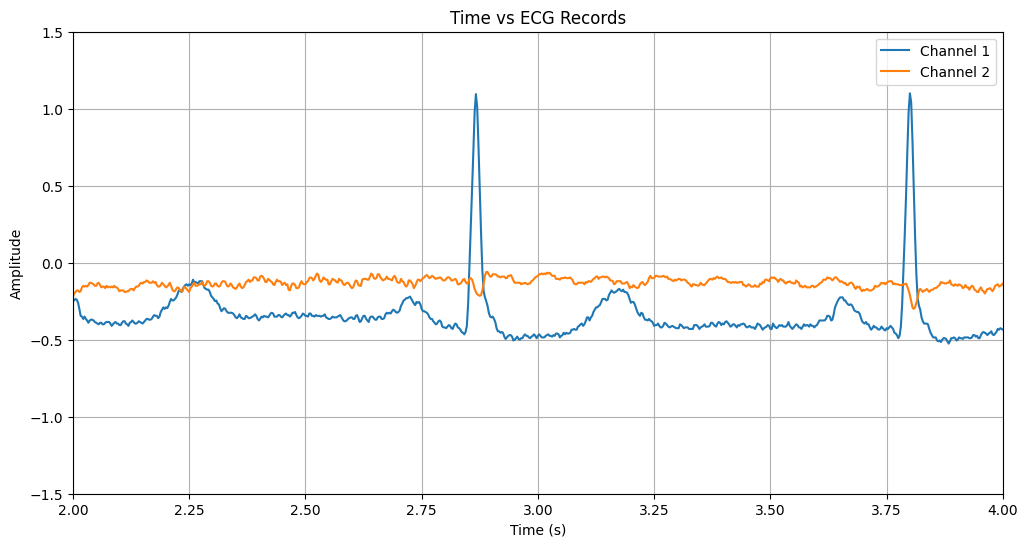

In [10]:
# Extract the signal
signal = record.p_signal

# Get the sampling frequency
sampling_frequency = record.fs

# Create a time array in seconds
time = np.arange(signal.shape[0]) / sampling_frequency

# Plot the signal with respect to time
plt.figure(figsize=(12, 6))
plt.plot(time, signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time vs ECG Records')
plt.grid(True)
plt.xlim(2, 4)
plt.ylim(-1.5, 1.5)
plt.legend(["Channel 1","Channel 2"])
plt.show()

## Plot the signals

Record Name: 101
Signal Shape: (650000, 2)
Annotations: 1874 annotations


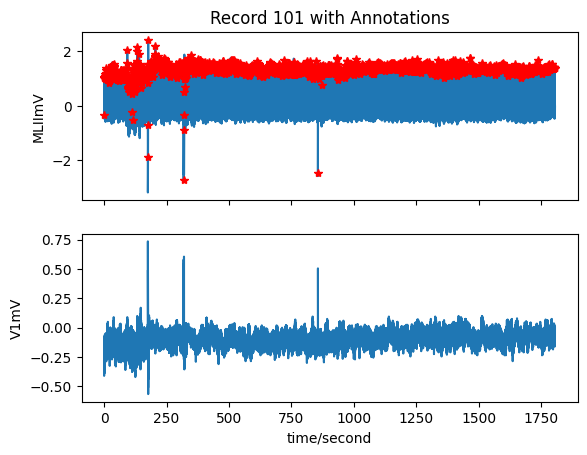

In [11]:
# Load the record and the corresponding annotations
record = wfdb.rdrecord(record_paths[0])
annotation = wfdb.rdann(record_paths[0], 'atr')

# Print some information about the record
print(f"Record Name: {record.record_name}")
print(f"Signal Shape: {record.p_signal.shape}")
print(f"Annotations: {len(annotation.sample)} annotations")

# Plot the signals
wfdb.plot_wfdb(record=record, annotation=annotation, title=f"Record {record.record_name} with Annotations")

# Label the dataset

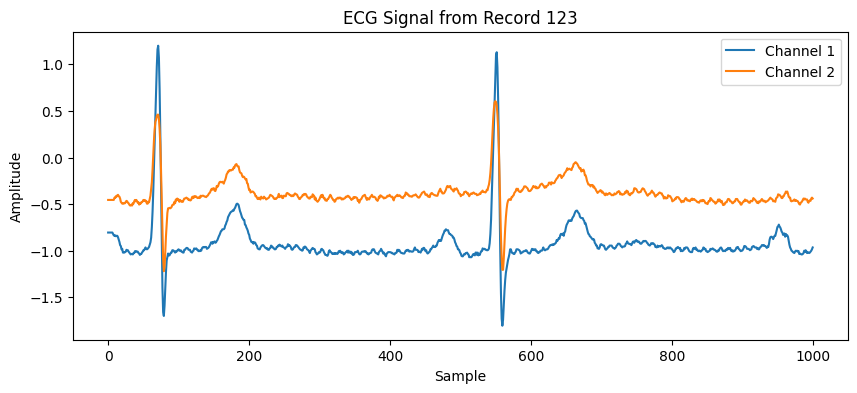

Annotations:
Number of Annotations : 1519
Sample: 25, Type: +
Sample: 70, Type: N
Sample: 550, Type: N
Sample: 1021, Type: N
Sample: 1498, Type: N
Sample: 1925, Type: N
Sample: 2340, Type: N
Sample: 2821, Type: N
Sample: 3259, Type: N
Sample: 3667, Type: N


In [12]:
# Example: Read record 123
record_name = '123'
record = wfdb.rdrecord(f'{dataset_dir}/{record_name}')
annotation = wfdb.rdann(f'{dataset_dir}/{record_name}', 'atr')

# Plot the ECG signal
plt.figure(figsize=(10, 4))
plt.plot(record.p_signal[:1000])
plt.title(f'ECG Signal from Record {record_name}')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(["Channel 1","Channel 2"])
plt.show()

# Print annotations
print("Annotations:")
print('Number of Annotations :',len(annotation.sample))
for i in range(10):
    print(f"Sample: {annotation.sample[i]}, Type: {annotation.symbol[i]}")

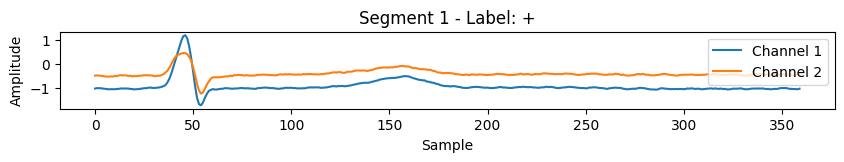

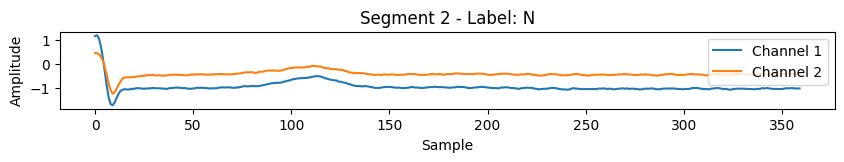

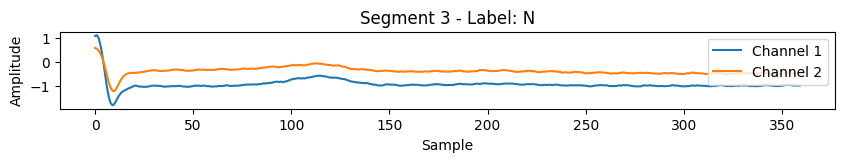

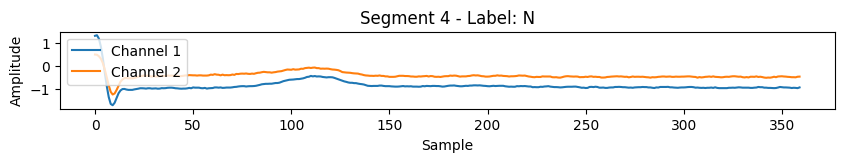

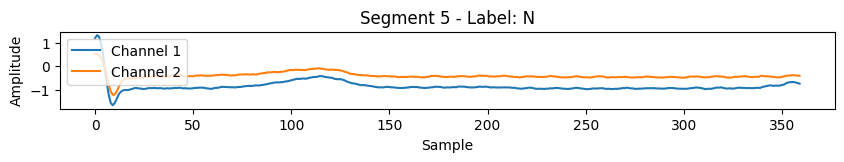

In [13]:
# Define a function to extract labeled segments
def extract_labeled_segments(record, annotation, segment_length=360):
    labeled_segments = []
    
    for i in range(len(annotation.sample)):
        start = annotation.sample[i]
        end = start + segment_length
        
        if end < len(record.p_signal):
            segment = record.p_signal[start:end]
            label = annotation.symbol[i]
            labeled_segments.append((segment, label))
    
    return labeled_segments

# Extract labeled segments
segments = extract_labeled_segments(record, annotation)

# Display some labeled segments
for i, (segment, label) in enumerate(segments[:5]):
    plt.figure(figsize=(10, 1))
    plt.plot(segment)
    plt.title(f'Segment {i+1} - Label: {label}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(["Channel 1","Channel 2"])
    plt.show()

## Extract labeled segments from a record with annotations

In [14]:
# Function to extract labeled segments from a record with annotations
def extract_labeled_segments(record, annotation, segment_length=360):
    """
    Extracts segments of ECG signals centered around annotation points and assigns corresponding labels.

    Parameters:
    - record: wfdb.Record object containing the ECG signal data.
    - annotation: wfdb.Annotation object containing the annotations for the record.
    - segment_length: int, length of each segment to be extracted.

    Returns:
    - labeled_segments: list of tuples, each containing a segment and its corresponding label.
    """
    Segments = []
    labels    = []
    
    for i in range(len(annotation.sample)):
        # Calculate the start and end indices of the segment
        start = annotation.sample[i] - segment_length // 2
        end = annotation.sample[i] + segment_length // 2
        
        # Ensure the segment indices are within the bounds of the signal
        if start >= 0 and end < len(record.p_signal):
            # Extract segments from both leads (assuming two leads)
            segment = record.p_signal[start:end, :2]  # Extracting both channels
            Segments.append(segment)
            label = annotation.symbol[i]
            labels.append(label)
    return Segments, labels

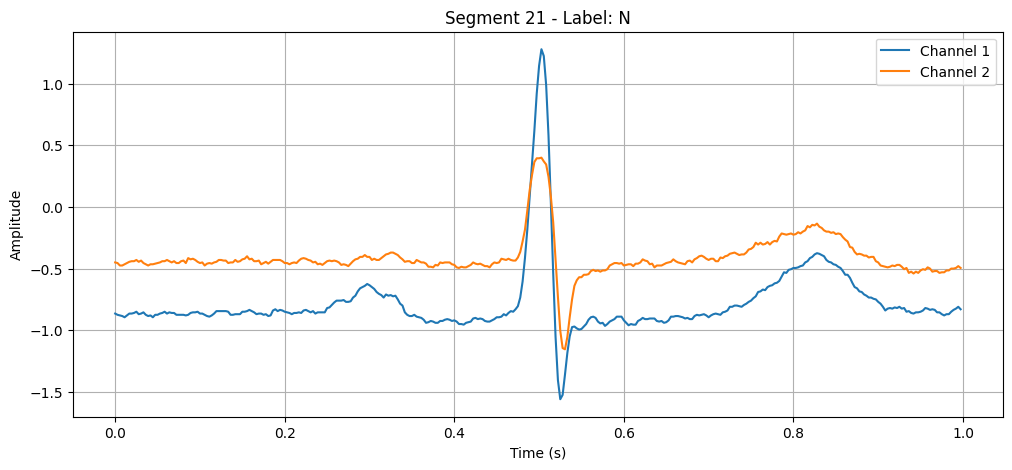

In [15]:
segment_length=360
Segments, labels =extract_labeled_segments(record, annotation, segment_length)

# Extract the signal
i=20
signal = Segments[i]
label = labels[i]
# Get the sampling frequency
sampling_frequency = segment_length

# Create a time array in seconds
time = np.arange(signal.shape[0]) / sampling_frequency
#time = np.arange(sampling_frequency)

# Plot the signal with respect to time
plt.figure(figsize=(12, 5))
plt.plot(time, signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Segment {i+1} - Label: {label}')
plt.legend(["Channel 1","Channel 2"])
plt.grid(True)
plt.show()

## Store all segments and labels

In [16]:
%%time
# Initialize a list to store all segments and labels
all_segments = {'Records':[],
               'Labels':[]}

# Process each record
for record_path in tqdm(record_paths[:5]):
    # Read the ECG record and its annotations
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')
    
    # Extract labeled segments from the record
    segments, labels = extract_labeled_segments(record, annotation)
    all_segments['Records'].extend(segments)
    all_segments['Labels'].extend(labels)

100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

CPU times: user 432 ms, sys: 22.4 ms, total: 454 ms
Wall time: 453 ms


In [17]:
print(all_segments.keys())
print('No of records :',len(all_segments['Records']))
# Check a record:
index=1
print('Record Shape :',all_segments['Records'][index].shape)
print('Label :',all_segments['Labels'][index])
all_segments['Records'][0][-1]
#all_segments[index][0][:,1]

dict_keys(['Records', 'Labels'])
No of records : 11335
Record Shape : (360, 2)
Label : N


array([-0.265, -0.185])

# Build and Store the Data into DataFrame

In [18]:
%%time
df = pd.DataFrame(all_segments)
segment_length=360
num_channels=2
column_names = [f'sample_{i}_ch_{j}' for i in range(segment_length) for j in range(num_channels)]

df[column_names]=[record.flatten() for record in tqdm(df['Records'])]
df.drop(columns=['Records'], inplace=True)
df.shape

100%|██████████| 11335/11335 [00:00<00:00, 163725.46it/s]


CPU times: user 4 s, sys: 315 ms, total: 4.32 s
Wall time: 4.31 s


(11335, 721)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11335 entries, 0 to 11334
Columns: 721 entries, Labels to sample_359_ch_1
dtypes: float64(720), object(1)
memory usage: 62.4+ MB


## Save the Cleaned Data Files into CSV format

In [20]:
%%time
# Save to CSV
output_csv_path = os.getcwd()+'MIT_BIH_Arrhythmia_labeled_segments.csv'
df.to_csv(output_csv_path, index=False)

print(f'Data saved to {output_csv_path}')

Data saved to /kaggle/workingMIT_BIH_Arrhythmia_labeled_segments.csv
CPU times: user 10.7 s, sys: 73.8 ms, total: 10.8 s
Wall time: 10.8 s


In [21]:
# Load the data
df = pd.read_csv(output_csv_path)
df.head()

,Labels,sample_0_ch_0,sample_0_ch_1,sample_1_ch_0,sample_1_ch_1,sample_2_ch_0,sample_2_ch_1,sample_3_ch_0,sample_3_ch_1,sample_4_ch_0,...,sample_355_ch_0,sample_355_ch_1,sample_356_ch_0,sample_356_ch_1,sample_357_ch_0,sample_357_ch_1,sample_358_ch_0,sample_358_ch_1,sample_359_ch_0,sample_359_ch_1
0,N,-0.355,-0.205,-0.355,-0.190,-0.365,-0.175,-0.345,-0.175,-0.345,...,-0.265,-0.185,-0.27,-0.165,-0.260,-0.160,-0.260,-0.175,-0.265,-0.185
1,N,-0.295,-0.165,-0.295,-0.180,-0.310,-0.200,-0.320,-0.200,-0.305,...,-0.340,-0.140,-0.34,-0.175,-0.350,-0.180,-0.340,-0.150,-0.325,-0.135
2,N,-0.365,-0.160,-0.365,-0.145,-0.345,-0.125,-0.350,-0.120,-0.360,...,-0.415,-0.140,-0.41,-0.145,-0.400,-0.145,-0.415,-0.135,-0.415,-0.125
3,N,-0.425,-0.110,-0.425,-0.105,-0.400,-0.105,-0.405,-0.115,-0.415,...,-0.340,-0.155,-0.32,-0.155,-0.330,-0.155,-0.340,-0.165,-0.330,-0.170
4,N,-0.330,-0.110,-0.335,-0.125,-0.340,-0.135,-0.355,-0.150,-0.365,...,-0.450,-0.125,-0.47,-0.140,-0.485,-0.130,-0.470,-0.125,-0.450,-0.090


## Check the Unique labels

In [22]:
df.Labels.unique()

array(['N', '~', '|', 'Q', 'A', '+', 'V', '/', 'f', 'R'], dtype=object)

The MIT-BIH Arrhythmia Database uses a variety of annotations to denote different types of beats and rhythm changes. Below is the meaning of each label:

- **N**: Normal beat
- **A**: Atrial premature beat
- **V**: Premature ventricular contraction
- **~**: Signal quality change
- **|**: Isolated QRS-like artifact
- **Q**: Unclassifiable beat
- **/**: Pace spike
- **f**: Fusion of ventricular and normal beat
- **+**: Rhythm change
- **x**: Non-conducted P-wave (blocked APB)
- **F**: Fusion of paced and normal beat
- **j**: Nodal (junctional) escape beat
- **L**: Left bundle branch block beat
- **a**: Aberrated atrial premature beat
- **J**: Nodal (junctional) premature beat
- **R**: Right bundle branch block beat
- **[**: Start of ventricular flutter/fibrillation
- **!**: Ventricular flutter wave
- **]**: End of ventricular flutter/fibrillation
- **E**: Ventricular escape beat
- **S**: Supraventricular premature beat
- **"**: Ventricular premature beat
- **e**: Atrial escape beat

These labels represent different types of cardiac events and abnormalities, which are essential for the analysis of arrhythmias and other cardiac conditions. The labels can be grouped into categories such as normal beats, abnormal beats, artifacts, and rhythm changes.

# Categorize the Annotations into Broader Categories
Categorize the annotations into broader categories to simplify the classification task. Here's a possible grouping of the annotations into top categories:

1. **Normal beats (N)**
2. **Abnormal beats (A, V, L, R, E, F, J, a, S)**
3. **Artifacts and noise (~, |, /, x, +, [ , ], ", Q, !)**
4. **Fusion beats (f)**
5. **Escape beats (e, j)**

Here’s how you can categorize these labels in your dataset:

- **Normal beats**:
  - `N`

- **Abnormal beats**:
  - `A`: Atrial premature beat
  - `V`: Premature ventricular contraction
  - `L`: Left bundle branch block beat
  - `R`: Right bundle branch block beat
  - `E`: Ventricular escape beat
  - `F`: Fusion of paced and normal beat
  - `J`: Nodal (junctional) premature beat
  - `a`: Aberrated atrial premature beat
  - `S`: Supraventricular premature beat

- **Artifacts and noise**:
  - `~`: Signal quality change
  - `|`: Isolated QRS-like artifact
  - `/`: Pace spike
  - `x`: Non-conducted P-wave (blocked APB)
  - `+`: Rhythm change
  - `[`: Start of ventricular flutter/fibrillation
  - `!`: Ventricular flutter wave
  - `]`: End of ventricular flutter/fibrillation
  - `"`: Ventricular premature beat
  - `Q`: Unclassifiable beat

- **Fusion beats**:
  - `f`: Fusion of ventricular and normal beat

- **Escape beats**:
  - `e`: Atrial escape beat
  - `j`: Nodal (junctional) escape beat

Let's create a mapping and apply it to the DataFrame to categorize the labels:

In [23]:
# Define the label mapping
label_mapping = {
    'N': 'Normal',
    'A': 'Abnormal',
    'V': 'Abnormal',
    'L': 'Abnormal',
    'R': 'Abnormal',
    'E': 'Abnormal',
    'F': 'Abnormal',
    'J': 'Abnormal',
    'a': 'Abnormal',
    'S': 'Abnormal',
    '~': 'Artifact',
    '|': 'Artifact',
    '/': 'Artifact',
    'x': 'Artifact',
    '+': 'Artifact',
    '[': 'Artifact',
    '!': 'Artifact',
    ']': 'Artifact',
    '"': 'Artifact',
    'Q': 'Artifact',
    'f': 'Fusion',
    'e': 'Escape',
    'j': 'Escape'
}

In [24]:
# Apply the mapping to the label column
df['category'] = df['Labels'].map(label_mapping)

# Drop the original label column if you only need the categories
df.drop(columns=['Labels'], inplace=True)

# Split Input & Target Features

In [25]:
classes= df.category.nunique()
df.category.unique()

array(['Normal', 'Artifact', 'Abnormal', 'Fusion'], dtype=object)

In [26]:
df['category'].value_counts()

category
Normal      7230
Abnormal    1991
Artifact    1854
Fusion       260
Name: count, dtype: int64

In [27]:
# Create a mapping from category names to integers
category_mapping = {label: idx for idx, label in enumerate(df['category'].unique())}
df['category'] = df['category'].map(category_mapping)

In [28]:
records = df.drop(['category'], axis=1).values
labels  = df['category'].values

## Balance the dataset using SMOTE

In [29]:
# Assuming `X` contains your features and `y` contains the target labels
smote = SMOTE(random_state=123)
balanced_records, balanced_labels = smote.fit_resample(records, labels)

# Display new class counts
print(Counter(balanced_labels))

Counter({0: 7230, 1: 7230, 2: 7230, 3: 7230})


In [30]:
# Reshape the data
Balanced_records= balanced_records.reshape((balanced_records.shape[0],360,2))

# Convert target variables to categorical values
Balanced_labels=to_categorical(balanced_labels)
print(Balanced_records.shape,Balanced_labels.shape)

(28920, 360, 2) (28920, 4)


## Split the data into train and test

In [31]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Balanced_records, Balanced_labels, test_size=0.2,shuffle=True, random_state=42)

# Check the shape of the target variables
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (23136, 360, 2), y_train shape: (23136, 4)
X_test shape: (5784, 360, 2), y_test shape: (5784, 4)


# Build & Train the model

In [32]:
def build_model(input_shape, num_classes):
    """
    Build a CNN model for classification of ECG signals.

    Parameters:
    - input_shape: tuple, shape of the input data (360, 2).
    - num_classes: int, number of output classes.

    Returns:
    - model: keras.Model object, the compiled model.
    """
    input_layer = keras.layers.Input(shape=input_shape)

    # First Conv1D layer with BatchNormalization and SpatialDropout
    conv1 = keras.layers.Conv1D(filters=128, kernel_size=15, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)
    conv1 = keras.layers.SpatialDropout1D(0.1)(conv1)

    # Second Conv1D layer with BatchNormalization and SpatialDropout
    conv2 = keras.layers.Conv1D(filters=256, kernel_size=10, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)
    conv2 = keras.layers.SpatialDropout1D(0.1)(conv2)

    # Third Conv1D layer with BatchNormalization and Dropout
    conv3 = keras.layers.Conv1D(filters=512, kernel_size=5, padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)
    conv3 = keras.layers.Dropout(0.2)(conv3)

    # Global Average Pooling layer
    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

    # Output layer
    output_layer = keras.layers.Dense(units=num_classes, activation='sigmoid', name='output_layer')(gap_layer)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Define input shape and number of classes
input_shape = (360, 2)  # Shape of each sample
num_classes =  classes #5

# Build and compile the model
model = build_model(input_shape, num_classes)

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 360, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 360, 128)       │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 360, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 360, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 360, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 360, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 360, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 360, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 360, 256)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 360, 512)       │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 360, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 360, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 360, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993,412 (3.79 MB)

 Trainable params: 991,620 (3.78 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [33]:
# Define callbacks (optional)
model_dir = os.getcwd() + '/model/'
os.makedirs(model_dir, exist_ok=True)  # Ensure the model directory exists

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(model_dir + 'best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=70,  # Increase epochs as needed
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/70
  5/290 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5467 - loss: 1.1136

I0000 00:00:1719137315.889322      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


290/290 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - accuracy: 0.8947 - loss: 0.3607 - val_accuracy: 0.4922 - val_loss: 1.9577
Epoch 2/70
290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9559 - loss: 0.1407 - val_accuracy: 0.9605 - val_loss: 0.1310
Epoch 3/70
290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9659 - loss: 0.1021 - val_accuracy: 0.9635 - val_loss: 0.1079
Epoch 4/70
290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9673 - loss: 0.0916 - val_accuracy: 0.9715 - val_loss: 0.0806
Epoch 5/70
290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9724 - loss: 0.0813 - val_accuracy: 0.9732 - val_loss: 0.0624
Epoch 6/70
290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9754 - loss: 0.0720 - val_accuracy: 0.9860 - val_loss: 0.0504
Epoch 7/70
290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9765 - loss: 0.0668 - val_accuracy: 0.9780 - val_loss: 0.0690
Epoch 8/70
290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9788 - loss: 0.0760 - val_accuracy: 0.97

# Evaluate the model 

In [34]:
# Load the best model
model.load_weights(model_dir + 'best_model.keras')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9956 - loss: 0.0163
Test Loss: 0.018116647377610207, Test Accuracy: 0.9948132634162903


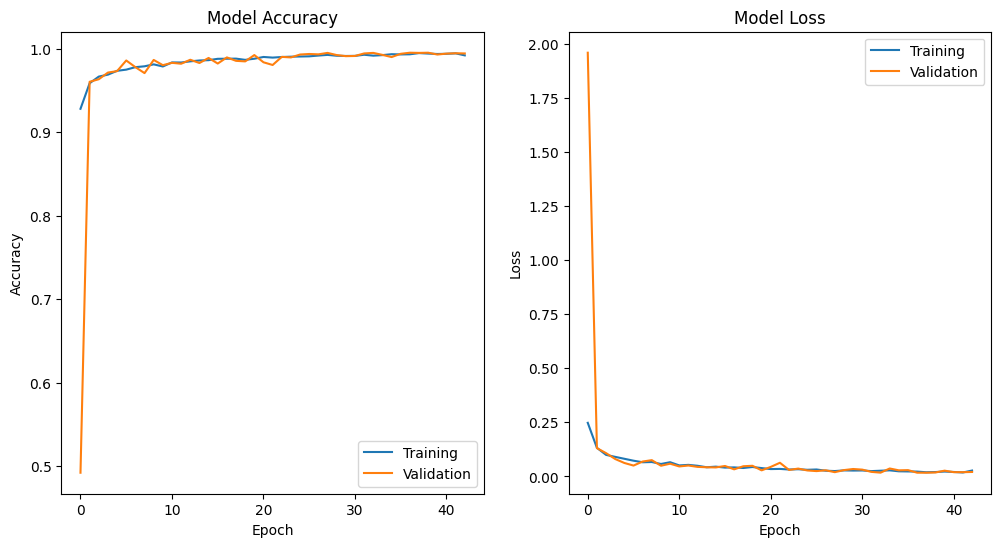

In [35]:
# Function to plot accuracy and loss
def evaluate_model(history):
    # Create subplots with 1 row and 2 columns
    fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot accuracy on the first subplot
    ax_acc.plot(history.history['accuracy'])
    ax_acc.plot(history.history['val_accuracy'])
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_title('Model Accuracy')
    ax_acc.legend(['Training', 'Validation'], loc='lower right')
    
    # Plot loss on the second subplot
    ax_loss.plot(history.history['loss'])
    ax_loss.plot(history.history['val_loss'])
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Model Loss')
    ax_loss.legend(['Training', 'Validation'], loc='upper right')
    
    # Show the plots
    plt.show()

# Evaluate the training process
evaluate_model(history)

## Save and Load the model

In [36]:
# save entire model to a HDF5 file
model.save('ECG_model.h5')

# Recreate the exact same model, including weights and optimizer.
ECG_model = keras.models.load_model('ECG_model.h5')
ECG_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 360, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 360, 128)       │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 360, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 360, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 360, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 360, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 360, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 360, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 360, 256)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 360, 512)       │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 360, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 360, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 360, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993,414 (3.79 MB)

 Trainable params: 991,620 (3.78 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 2 (12.00 B)

In [37]:
y_pred=ECG_model.predict(X_test)

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


## Confusion matrix

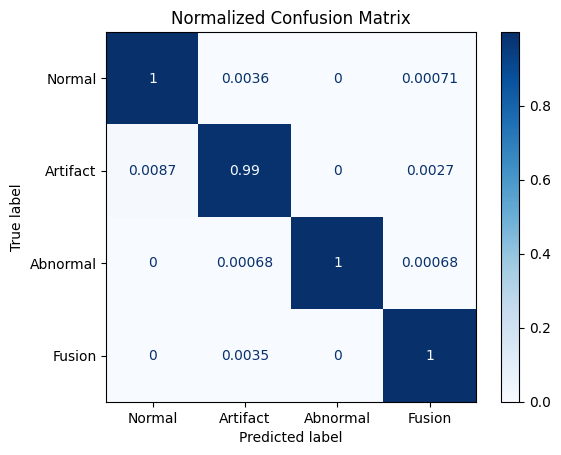

In [38]:
# Assuming cat_map and your predictions y_test, y_pred are already defined
cat_map = {value: item for item, value in category_mapping.items()}

# Compute confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=cat_map.values())
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()

## Classification Report

In [39]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=cat_map.values()))

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      1403
    Artifact       0.99      0.99      0.99      1486
    Abnormal       1.00      1.00      1.00      1475
      Fusion       1.00      1.00      1.00      1420

    accuracy                           0.99      5784
   macro avg       0.99      0.99      0.99      5784
weighted avg       0.99      0.99      0.99      5784



# Predictions

In [40]:
# Predict on a single sample
prediction = ECG_model.predict(X_train[-1].reshape((1, 360, 2)))
print(cat_map[prediction.argmax()])
print(cat_map[y_train[-1].argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
Fusion
Fusion


In [41]:
class ECG_Signal_Classifications:
    def __init__(self, model_dir):
        self.model_path= model_dir
        self.Category  = {0: 'Normal', 
                          1: 'Abnormal', 
                          2: 'Artifact', 
                          3: 'Fusion', 
                          4: 'Escape'}
        self.segment_length = 360

    def load_model(self):
        model = keras.models.load_model(self.model_path)
        print("Model Successfully Loaded")
        return model
    def data_preprocessing(self,data_dir,n=7):
        if data_dir.endswith('.hea'):
            record_path = os.path.splitext(data_dir)[0]
        elif data_dir.endswith('.dat'):
            record_path = os.path.splitext(data_dir)[0]
        else:
            record_path=data_dir

        # Load the record
        """
          sampfrom : Sampling starting point [360, Assuming starting sample may be not correct]
          sampto   : Sampling ending Point   [n*360]
        """
        record = wfdb.rdrecord(record_path, sampfrom=360,sampto=360*n)
        
        return record.p_signal
    
    def predictions(self,data_dir):
        Records   = self.data_preprocessing(data_dir)
        ECG_model = self.load_model()
        pred_labels = []
        # Calculate the total number of segments
        total_segments = len(Records) // self.segment_length

        # Ensure the segment indices are within the bounds of the signal
        for i in tqdm(range(total_segments), desc="Processing segments"):
            # Move to the next segment
            start = i * self.segment_length
            end = start + self.segment_length

            # Extract segments from both leads (assuming two leads)
            if Records.shape[1] >= 2:
                segment = Records[start:end, :2]  # Extracting both channels
            else:
                segment = np.tile(Records[start:end, :1], (1, 2))  # Duplicate the single channel
            
            if segment.shape[0] == self.segment_length:
                # Predict on a single sample
                prediction = ECG_model.predict(segment.reshape((1, 360, 2)))
                prediction = prediction.argmax()

                # Reverse the mapping
                pred_label = self.Category[prediction]
                pred_labels.append(pred_label)
        
        return pred_labels

In [42]:
# Trained_Model_path
model_dir='ECG_model.h5'
data_dir= record_paths[1]
ECG=ECG_Signal_Classifications(model_dir)
print(ECG.predictions(data_dir))

Model Successfully Loaded


Processing segments:   0%|          | 0/6 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Processing segments:  17%|█▋        | 1/6 [00:00<00:01,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing segments:  50%|█████     | 3/6 [00:00<00:00,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Processing segments:  83%|████████▎ | 5/6 [00:00<00:00,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Processing segments: 100%|██████████| 6/6 [00:00<00:00,  8.75it/s]

['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal']


# Key Findings

The classification models achieved promising results, with the best-performing model reaching an accuracy of 99%. The precision, recall, and F1-score metrics also indicated strong performance, especially in detecting abnormal heartbeats.

## Future Work:

- Enhanced Preprocessing: With more sophisticated preprocessing techniques can further improve signal quality and thaat may result the improved model performance.
- Advanced Architectures: Implementing more advanced deep learning architectures, such as LSTM or transformer-based models, could potentially improve classification accuracy.
- Broader Dataset: Expanding the dataset to include more diverse ECG signals from different populations with equal propoetional for each calss would enhance the model's robustness and generalizability.

In conclusion, the project successfully demonstrated the potential of machine learning techniques in classifying ECG signals, providing a foundation for further research and development in this critical area of healthcare.